In [10]:
import cython
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pymc3 as pm
import pandas as pd

from lib.car_model import CAR2
from matplotlib.image import imread

from theano import scan
import theano.tensor as tt

from pymc3.distributions import continuous
from pymc3.distributions import distribution

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test  = x_test/255

def subset(label, data=x_train, labels=y_train):
    '''
    e.g. subset(3) -> gets all pictures of digit 3
    '''
    assert label >= 0 and label <= 9
    
    return data[np.argwhere(labels == 3)]

In [4]:
def plot(image, figsize=(16, 7)):
    
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='Greys')
    

def plot_many():
    pass

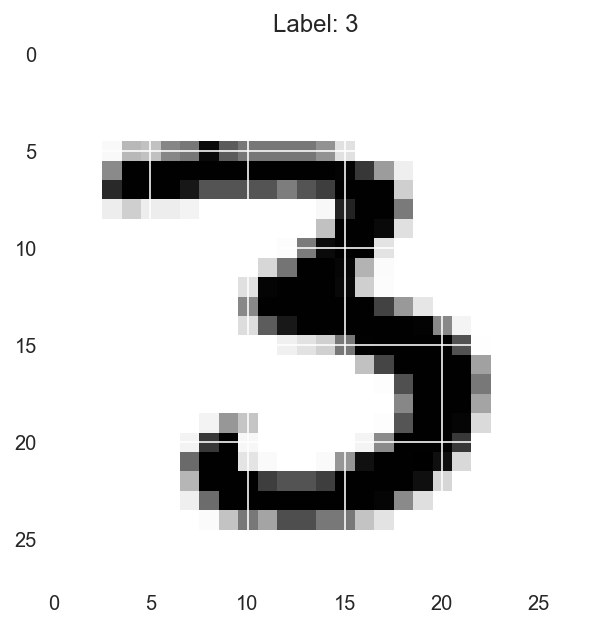

In [7]:
dummy = x_train[12]
plot(dummy, figsize=(10, 5))
_ = plt.title('Label: ' + str(y_train[12]))

In [15]:
pd.DataFrame(dummy).to_csv('handwritten_digit.csv', index=False, header=False)

In [27]:
O = np.concatenate(dummy)

Taken from https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

In [28]:
adj = []
position_matrix = np.linspace(0, 28*28 - 1, num=28*28).astype(np.int64).reshape(28, 28)
count = 0

for i, row in enumerate(position_matrix):
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // 28 == 0) and ((j + delta_j) // 28 == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

In [7]:
def pad(array, epsilon=1e-4):
    output = []
    
    for x in array:
        if x == 0:
            output.append(epsilon)
        elif x == 1:
            output.append(1 - epsilon)
        else:
            output.append(x)
            
    return output

In [8]:
with pm.Model() as model:
    beta0  = pm.Normal('beta0', mu=0., tau=1e-2)
    tau    = pm.Gamma('tau_c', alpha=1.0, beta=1.0)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau, shape=N)
    phi    = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi)) # zero-center phi
    
    
    mu = pm.Deterministic('mu', beta0 + phi)
    Yi = pm.LogitNormal('Yi', mu=mu, observed=pad(O))
    
    trace = pm.sample(draws=1000, chains=2)
    #trace = pm.sample(draws=2000, step=pm.Metropolis())
    posterior_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_phi, tau_c, beta0]
Sampling 2 chains: 100%|██████████| 3000/3000 [08:47<00:00, 10.26draws/s] 
The acceptance probability does not match the target. It is 0.8789801382114897, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 2000/2000 [00:01<00:00, 1630.56it/s]


Check average proportion of pixels equal to 0 and 1 (or near 1, i.e. 253 or 254)

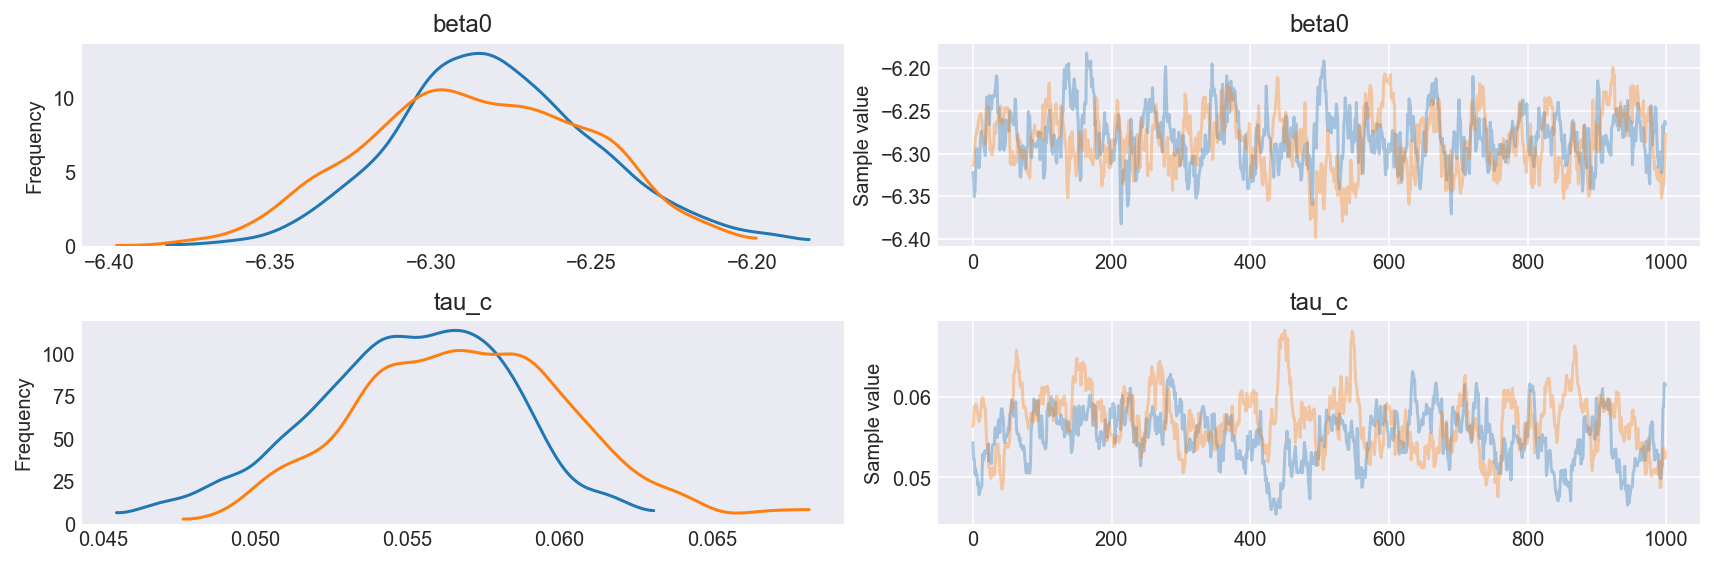

In [9]:
_ = pm.traceplot(trace, varnames=['beta0', 'tau_c'])

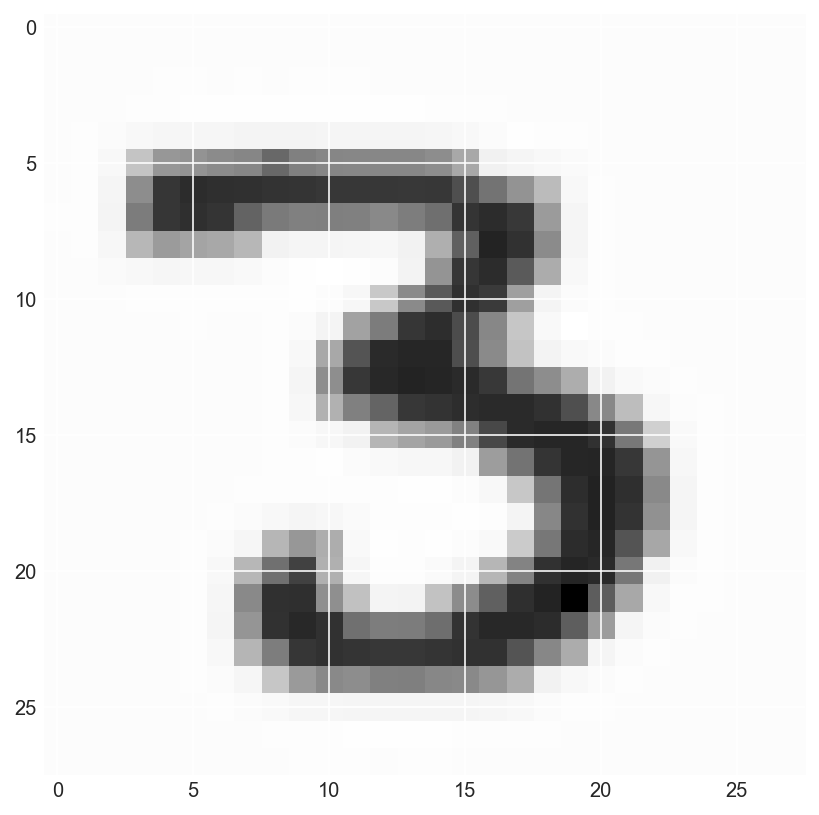

In [10]:
plot(np.mean(trace.get_values('phi'), axis=0).reshape(28, 28))

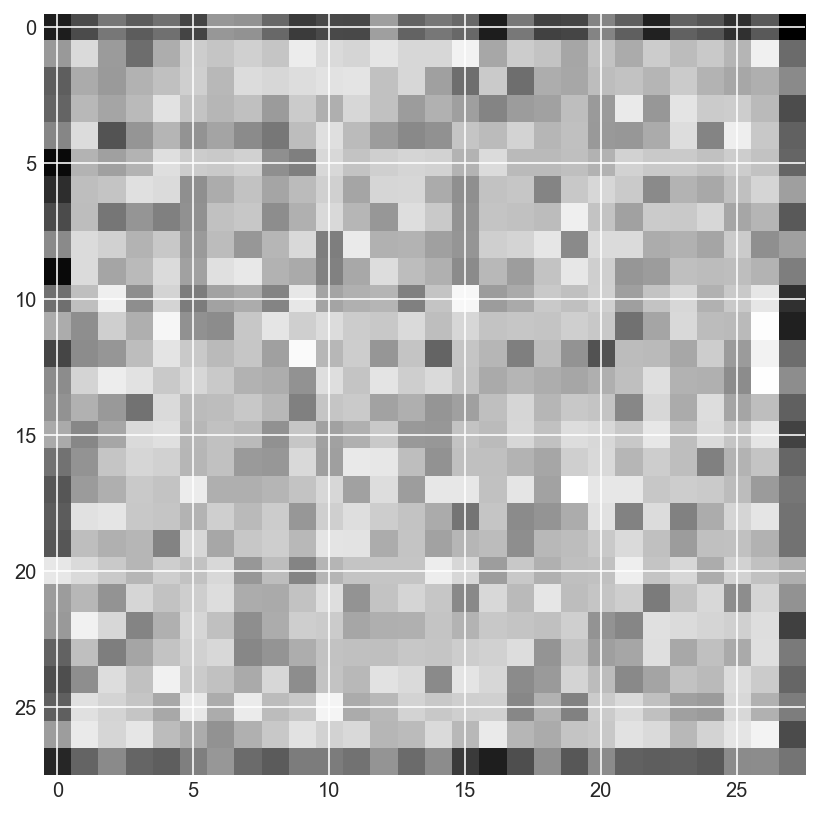

In [11]:
plot(np.std(trace.get_values('phi'), axis=0).reshape(28, 28))

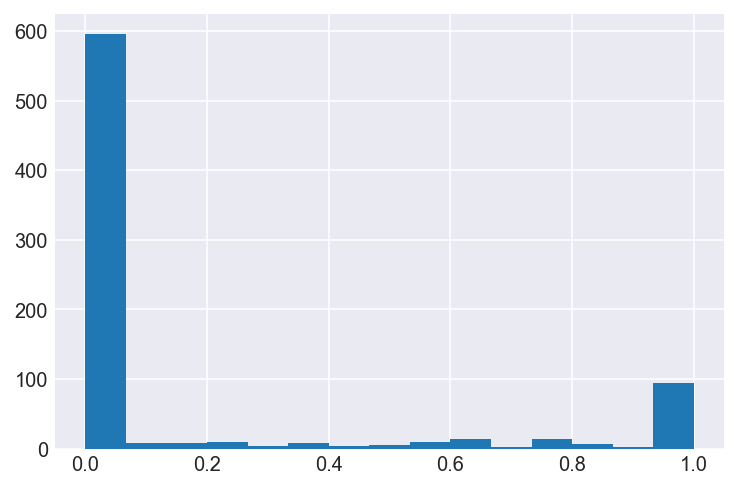

In [12]:
_ = plt.hist(x_train[12].reshape(-1), bins=15)

In [15]:
image = imread('images/malignant_R_MLO.png')
image.shape
x_dim, y_dim = image.shape

In [17]:
adj = []
position_matrix = np.linspace(0, x_dim*y_dim - 1, num=x_dim*y_dim).astype(np.int64).reshape(x_dim, y_dim)
count = 0

for i, row in enumerate(position_matrix):
    if i % 100 == 0:
        print('hello')
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // x_dim == 0) and ((j + delta_j) // y_dim == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, N))
amat = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat[i, a] = 1
    wmat[i, a] = weights[i]

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello


MemoryError: 